In [46]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from darts.models import RegressionModel
from sklearn import cross_decomposition
from darts.metrics import mape, r2_score, mae, mse
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier
import copy
import warnings

In [47]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))

In [48]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [49]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

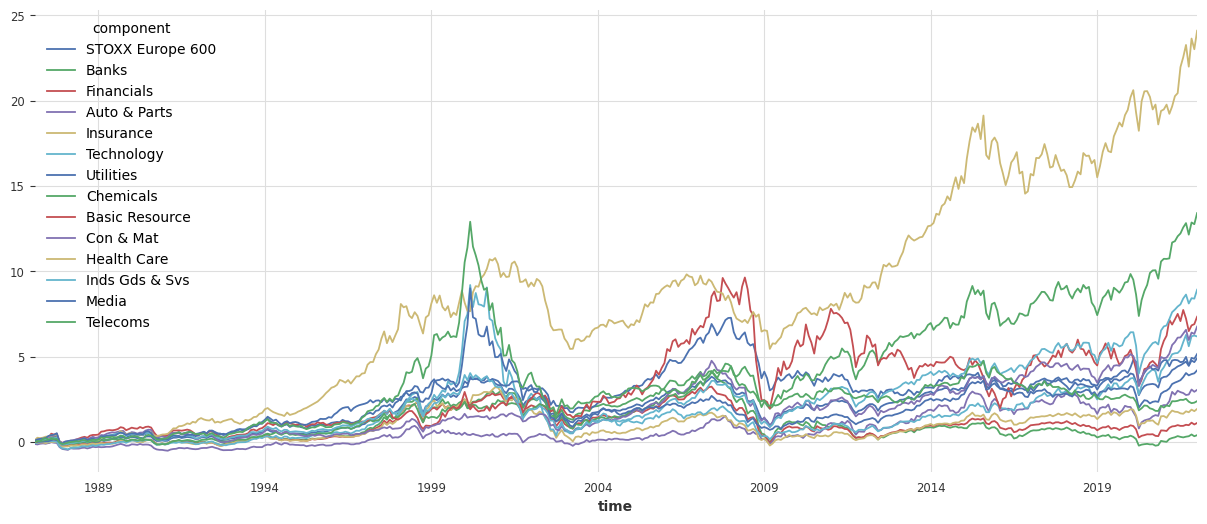

In [50]:
#from io import BytesIO
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);

In [51]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [52]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

In [53]:
# show length of train and test set
print('Length of train set: {}, length of test set: {}.'.format(len(train), len(test)))

Length of train set: 336, length of test set: 84.


## Benchmark Portfolios

Our main benchmark is the STOXX Europe 600 Index. Furthermore, we expand the benchmarks by computing the equal weighted portfolio and portfolio based on historical averages.

### Equal Weighted Portfolio

In [54]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

# create weights
weights_ew = 1/len(col_list)

# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


### Portfolio based on Historical Average

In [55]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# show the last 5 rows of portfolio_returns of historical average portfolio
portfolio_returns.tail(1)

component,equal_weighted,historical_average
time,,
2022-01-01,6.544394,10.913366


In [56]:
# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
Banks             0.033024
Financials        0.030685
Auto & Parts      0.021829
Insurance         0.027747
Technology        0.050778
Utilities         0.085845
Chemicals         0.108597
Basic Resource    0.099537
Con & Mat         0.061754
Health Care       0.258600
Inds Gds & Svs    0.076979
Media             0.063096
Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


## Dimensionality Reduction Methods

### Partial Least Squares

In [57]:
# pls regression model with 1 lag
pls_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.PLSRegression(n_components=5))
pls_model_1.fit(train)
pls_forecast_1 = pls_model_1.predict(len(test))

In [58]:
# first pls regression model with 1 lag
hf1_pls_regression = pls_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

Text(0, 0.5, 'Cumulative Returns in %')

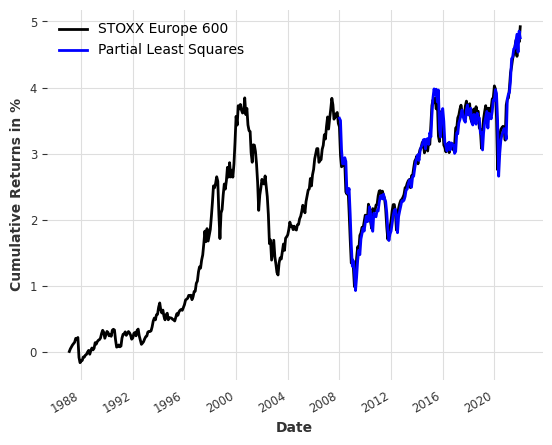

In [59]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(color= 'black', label='STOXX Europe 600')
hf1_pls_regression['STOXX Europe 600'].plot(color= 'blue', label='Partial Least Squares')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns in %')

#### Portfolio

In [60]:
# change the type of the pls forecast to pandas dataframe
pls_forecast_1 = pls_forecast_1.pd_dataframe()

In [61]:
# perform mean-variance optimization with the linear regression forecast
mu_pls_regression_1 = expected_returns.mean_historical_return(pls_forecast_1)
S_pls_regression_1 = risk_models.sample_cov(pls_forecast_1)

In [62]:
# optimize for maximal Sharpe ratio
ef_pls_regression_1 = EfficientFrontier(mu_pls_regression_1, S_pls_regression_1)
weights_pls_1 = ef_pls_regression_1.max_sharpe()

In [63]:
# print the weights in a table and round them to 3 decimals and add their sum
print('Weights for PLS regression: ' + str(np.round(pd.Series(weights_pls_1), 3)))

Weights for PLS regression: STOXX Europe 600    0.000
Banks               0.000
Financials          0.000
Auto & Parts        0.000
Insurance           0.000
Technology          0.000
Utilities           0.000
Chemicals           0.949
Basic Resource      0.051
Con & Mat           0.000
Health Care         0.000
Inds Gds & Svs      0.000
Media               0.000
Telecoms            0.000
dtype: float64


In [64]:
# compute the returns of the pls portfolio
pls_returns_1 = (cum_returns_portfolio * weights_pls_1).sum(axis=1)
# add portfolio returns to the dataframe
portfolio_returns['pls_regression_1'] = pls_returns_1

In [65]:
# print the portfolio return
print('PLS regression portfolio return: ' + str(np.round(portfolio_returns['pls_regression_1'].iloc[-1], 2)) + '%')

PLS regression portfolio return: 13.11%


### Canonical PLS

In [66]:
# canonical pls regression model with 1 lag
canonical_pls_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.PLSCanonical(n_components=10))
canonical_pls_model_1.fit(train)
canonical_pls_forecast_1 = canonical_pls_model_1.predict(len(test))

In [67]:
# first canonical pls model with 1 lag
hf1_canonical_pls = canonical_pls_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

Text(0, 0.5, 'Cumulative Returns in %')

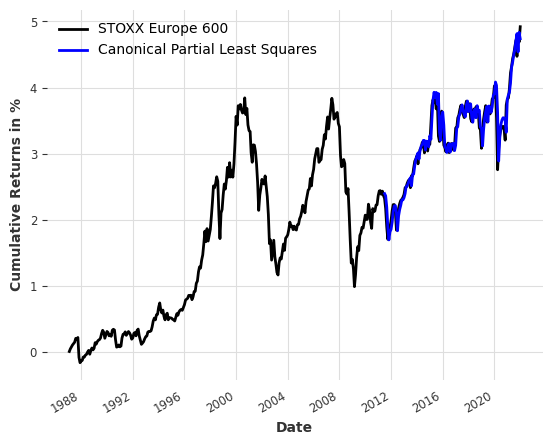

In [68]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(color= 'black', label='STOXX Europe 600')
hf1_canonical_pls['STOXX Europe 600'].plot(color= 'blue', label='Canonical Partial Least Squares')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns in %')

#### Portfolio

In [69]:
# change type of canonical pls forecast to pandas dataframe
canonical_pls_forecast_1 = canonical_pls_forecast_1.pd_dataframe()

In [70]:
# perform mean-variance optimization on the canonical pls forecast
mu_canonical_pls_1 = expected_returns.mean_historical_return(canonical_pls_forecast_1)
S_canonical_pls_1 = risk_models.sample_cov(canonical_pls_forecast_1)

In [71]:
# optimize for maximal Sharpe ratio
ef_canonical_pls_1 = EfficientFrontier(mu_canonical_pls_1, S_canonical_pls_1)
ef_canonical_pls_1.add_constraint(lambda x : x[0] == 0.00)
weights_canonical_pls_1 = ef_canonical_pls_1.max_sharpe()

In [72]:
# print the weights in a table and round them to 4 decimals
print('Weights for Canonical PLS: ' + str(np.round(pd.Series(weights_canonical_pls_1), 3)))


Weights for Canonical PLS: STOXX Europe 600    0.000
Banks               0.005
Financials          0.000
Auto & Parts        0.187
Insurance           0.000
Technology          0.003
Utilities           0.364
Chemicals           0.079
Basic Resource      0.011
Con & Mat           0.000
Health Care         0.181
Inds Gds & Svs      0.160
Media               0.010
Telecoms           -0.000
dtype: float64


In [73]:
# compute the returns of the canonical pls portfolio
canonical_returns_1 = (cum_returns_portfolio * weights_canonical_pls_1).sum(axis=1)
# add the canonical pls portfolio to the dataframe
portfolio_returns['canonical_pls_1'] = canonical_returns_1

In [74]:
# print the portfolio return
print('Canonical PLS portfolio return: ' + str(np.round(portfolio_returns['canonical_pls_1'].iloc[-1], 2)) + '%')

Canonical PLS portfolio return: 9.45%


### CCA

In [75]:
# cca regression model with 1 lag
cca_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.CCA(n_components=14))
cca_model_1.fit(train)
cca_forecast_1 = cca_model_1.predict(len(test))

In [76]:
# first cca model with 1 lag
hf1_cca = cca_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

Text(0, 0.5, 'Cumulative Returns in %')

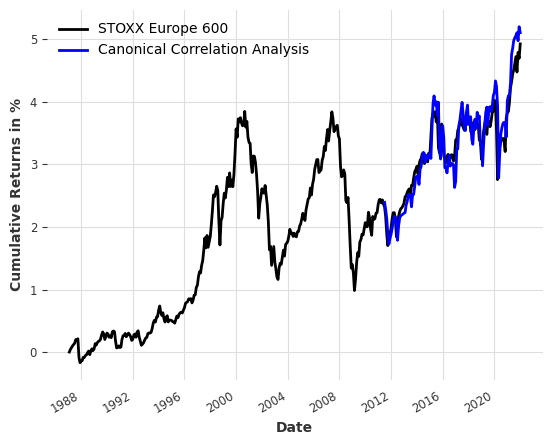

In [77]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(color= 'black', label='STOXX Europe 600')
hf1_cca['STOXX Europe 600'].plot(color= 'blue', label='Canonical Correlation Analysis')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns in %')

#### Portfolio

In [78]:
# change the type of the cca forecast to a dataframe
cca_forecast_1 = cca_forecast_1.pd_dataframe()

In [79]:
# perform mean-variance optimization on the cca forecast
mu_cca_1 = expected_returns.mean_historical_return(cca_forecast_1)
S_cca_1 = risk_models.sample_cov(cca_forecast_1)

In [80]:
# fill nan values with 0
mu_cca_1 = mu_cca_1.fillna(0)
S_cca_1 = S_cca_1.fillna(0)

In [81]:
# optimize for maximal Sharpe ratio
ef_cca_1 = EfficientFrontier(mu_cca_1, S_cca_1)
ef_cca_1.add_constraint(lambda x : x[0] == 0.00)
weights_cca_1 = ef_cca_1.max_sharpe()

In [82]:
# print the weights in a table and round them to 4 decimals
print('Weights for CCA: ' + str(np.round(pd.Series(weights_cca_1), 3)))

Weights for CCA: STOXX Europe 600    0.000
Banks               0.003
Financials          0.016
Auto & Parts        0.064
Insurance           0.009
Technology          0.070
Utilities           0.014
Chemicals          -0.015
Basic Resource     -0.016
Con & Mat          -0.013
Health Care         0.548
Inds Gds & Svs      0.075
Media               0.192
Telecoms            0.054
dtype: float64


In [83]:
# compute the returns of the cca regression
cca_returns_1 = (cum_returns_portfolio * weights_cca_1).sum(axis=1)
# add the cca returns to the portfolio returns
portfolio_returns['cca_regression_1'] = cca_returns_1

In [84]:
# show the last value of each portfolio in percent and round to 2 decimals
print('Last value of the CCA portfolio: ' + str(round(portfolio_returns['cca_regression_1'].iloc[-1], 2)) + '%')

Last value of the CCA portfolio: 15.15%


# Analysis Dimensionality Reduction

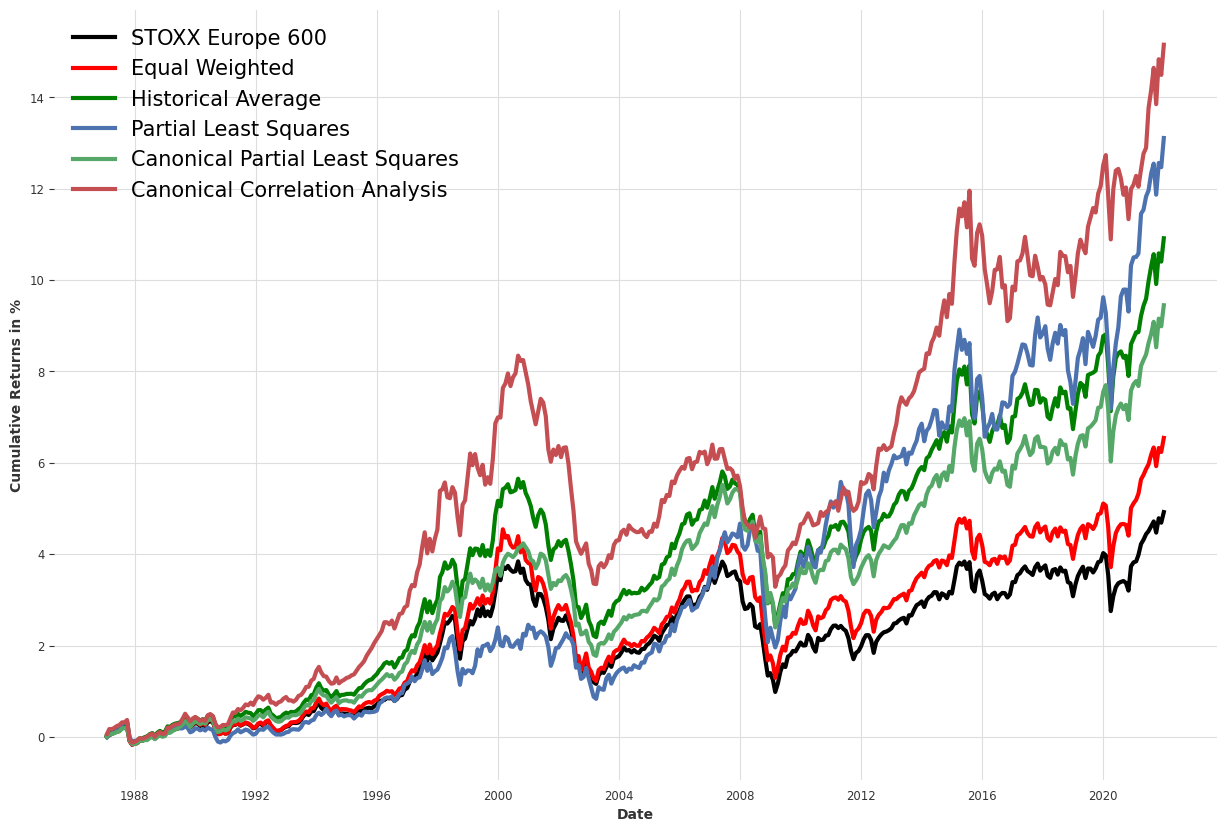

In [85]:
# plot the cumulative returns of the benchmark and the lasso regression portfolio
plt.figure(figsize=(15,10))

plt.plot(cum_returns_portfolio['STOXX Europe 600'], color= 'black', label='STOXX Europe 600', lw=3)
plt.plot(portfolio_returns['equal_weighted'], color= 'red', label='Equal Weighted', lw=3)
plt.plot(portfolio_returns['historical_average'], color= 'green', label='Historical Average', lw=3)
plt.plot(portfolio_returns['pls_regression_1'], label='Partial Least Squares', lw=3)
plt.plot(portfolio_returns['canonical_pls_1'], label='Canonical Partial Least Squares', lw=3)
plt.plot(portfolio_returns['cca_regression_1'], label='Canonical Correlation Analysis', lw=3)

plt.legend(loc='upper left', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns in %')

plt.show();

In [86]:
import tabulate

In [87]:
# create a dictionary with the portfolio returns
performance = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted', 'Historical Average', 'PLS Regression', 'PLS Canonical Regression', 'CCA Regression'],
    'Return': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0],
                portfolio_returns['equal_weighted'].tail(1).values[0],
                portfolio_returns['historical_average'].tail(1).values[0],
                portfolio_returns['pls_regression_1'].tail(1).values[0],
                portfolio_returns['canonical_pls_1'].tail(1).values[0],
                portfolio_returns['cca_regression_1'].tail(1).values[0]],
    'Volatility': [cum_returns_portfolio['STOXX Europe 600'].std(),
                 portfolio_returns['equal_weighted'].std(),
                    portfolio_returns['historical_average'].std(),
                    portfolio_returns['pls_regression_1'].std(),
                    portfolio_returns['canonical_pls_1'].std(),
                portfolio_returns['cca_regression_1'].std()]
}

# Create a DataFrame from the dictionary
performance = pd.DataFrame(performance)

# Set the index of the DataFrame to be the Portfolio column
performance.set_index('Portfolio', inplace=True)

# divide the values by 100 to get the percentage
performance[['Return', 'Volatility']] = performance[['Return', 'Volatility']].div(100)

# Format the DataFrame to display the values as percentages with only 2 decimal places
performance.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted,6.54%,1.63%
Historical Average,10.91%,2.67%
PLS Regression,13.11%,3.29%
PLS Canonical Regression,9.45%,2.32%
CCA Regression,15.15%,3.76%


In [88]:
# convert portfolio returns as pandas.core.Series to a darts.TimeSeries
# save the portfolio returns as csv file
portfolio_returns.to_csv('data/portfolio_returns_dimred.csv', index=True, header=True)

# get portfolio returns from csv file as TimeSeries
portfolio_returns_timeseries = TimeSeries.from_csv('data/portfolio_returns_dimred.csv', index_col= 0, parse_dates=True)

In [89]:
# create a table that includes the mape, mse and r2score for each portfolio

evaluation = {
    'Portfolio': ['PLS', 'PLS Canonical', 'CCA'],
    'MSE': [mse(hf1_pls_regression, cum_returns),
             mse(hf1_canonical_pls, cum_returns),
             mse(hf1_cca, cum_returns)],
    'MAE': [mae(hf1_pls_regression, cum_returns),
            mae(hf1_canonical_pls, cum_returns),
            mae(hf1_cca, cum_returns)],
    'R2': [r2_score(hf1_pls_regression, cum_returns),
            r2_score(hf1_canonical_pls, cum_returns),
            r2_score(hf1_cca, cum_returns)],
    'MAPE': [mape(hf1_pls_regression, cum_returns),
            mape(hf1_canonical_pls, cum_returns),
            mape(hf1_cca, cum_returns)]
}

# Create a DataFrame from the dictionary
evaluation = pd.DataFrame(evaluation)

# Set the index of the DataFrame to be the Portfolio column
evaluation.set_index('Portfolio', inplace=True)

# Divide the values by 100 to get the percentage
evaluation[['MSE', 'MAE', 'R2', 'MAPE']] = evaluation[['MSE', 'MAE', 'R2', 'MAPE']].div(100)

# Format the DataFrame to display the values as percentages
evaluation.style.format("{:.2%}")

,MSE,MAE,R2,MAPE
Portfolio,,,,
PLS,0.26%,0.32%,0.85%,17.49%
PLS Canonical,0.10%,0.20%,0.92%,8.29%
CCA,0.22%,0.30%,0.87%,12.12%


In [90]:
# save this table as csv file
evaluation.to_csv('data/evaluation_dimred.csv', index=True, header=True)